First few rows of the dataset:
   Age   Gender  BMI  Fever  Nausea/Vomting  Headache   Diarrhea   \
0    56       1   35      2               1          1          1   
1    46       1   29      1               2          2          1   
2    57       1   33      2               2          2          2   
3    49       2   33      1               2          1          2   
4    59       1   32      1               1          2          1   

   Fatigue & generalized bone ache   Jaundice   Epigastric pain   ...  ALT 36  \
0                                 2          2                 2  ...       5   
1                                 2          2                 1  ...      57   
2                                 1          1                 1  ...       5   
3                                 1          2                 1  ...      48   
4                                 2          2                 2  ...      94   

   ALT 48  ALT after 24 w  RNA Base   RNA 4   RNA 12  RNA EOT  RNA 

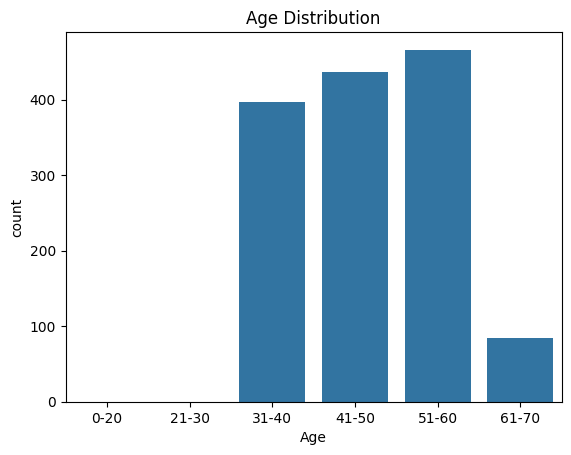

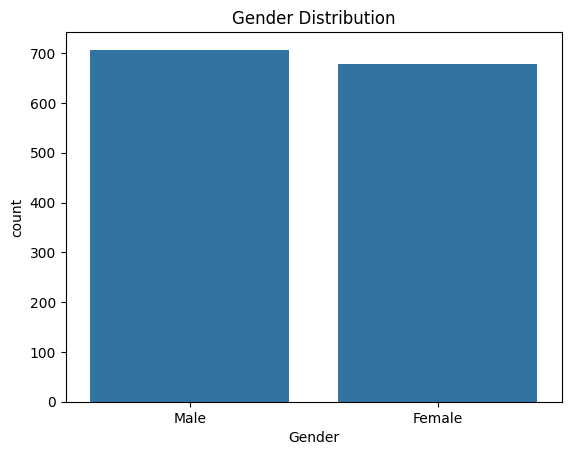

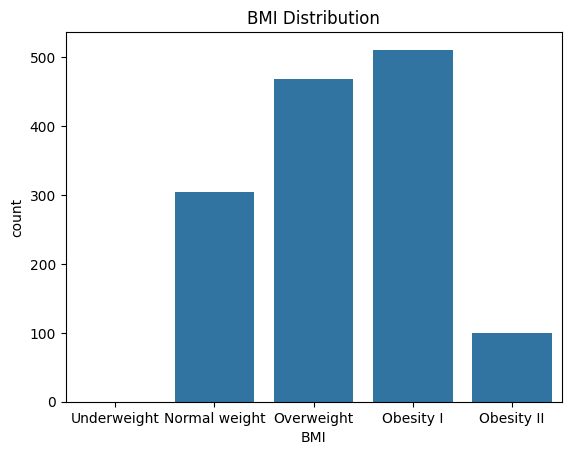

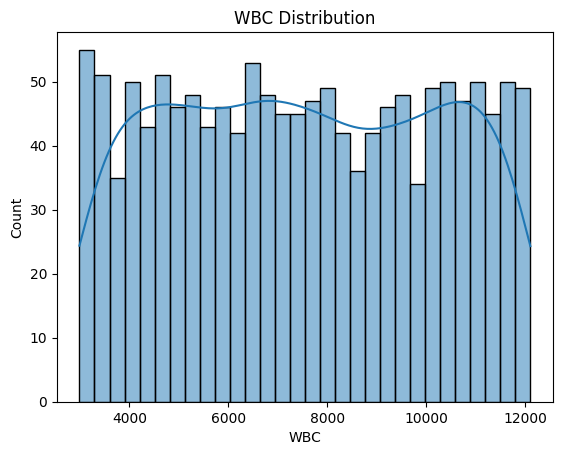

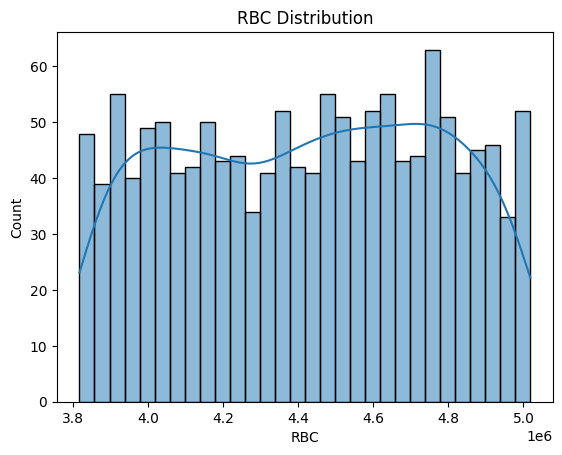

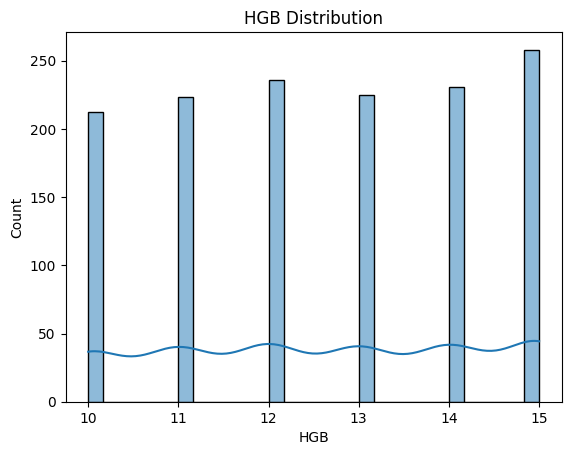

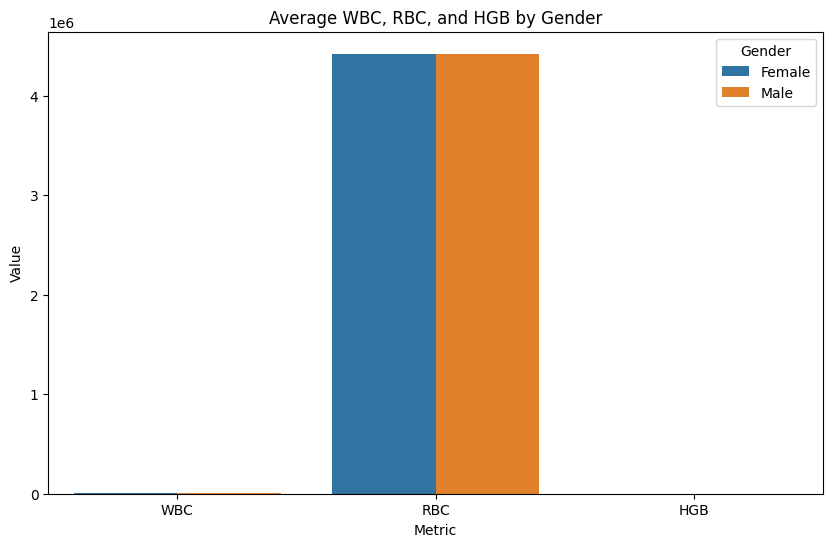

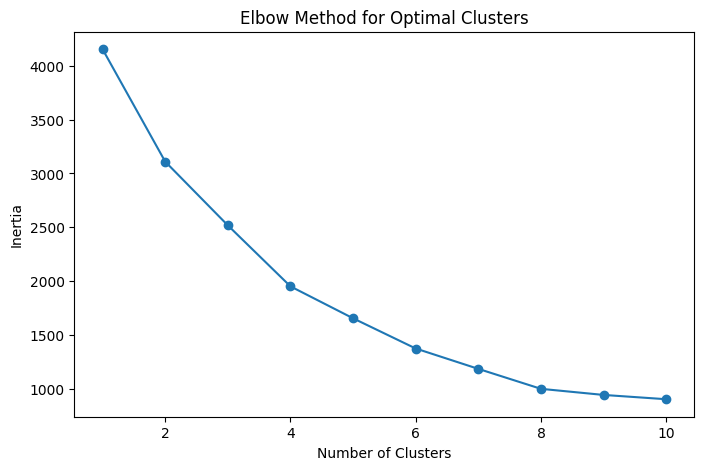

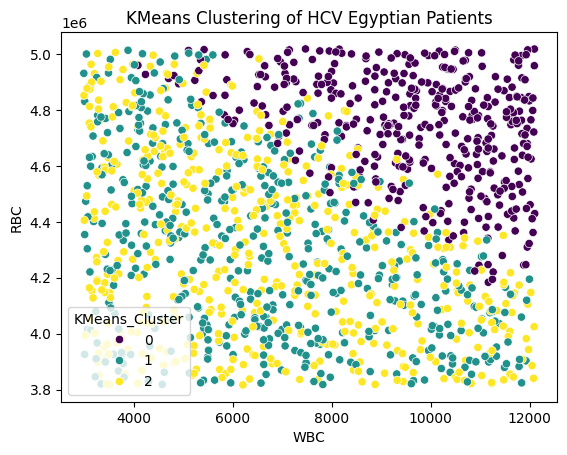

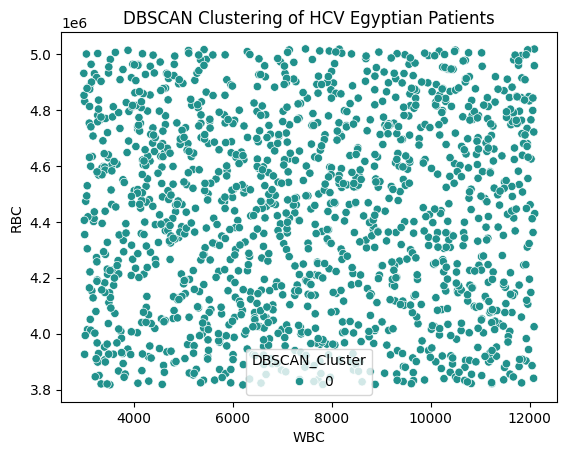

KMeans Silhouette Score: 0.2378737236589135
DBSCAN did not form valid clusters for Silhouette Score evaluation.


In [1]:
# Import necessary libraries
# These libraries are used for data manipulation, visualization, and clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
# The dataset is loaded from the specified file path
data_path = "d:\\Users\\dharm\\Downloads\\hepatitis+c+virus+hcv+for+egyptian+patients\\HCV-Egy-Data.csv"
data = pd.read_csv(data_path)

# Display basic info about the dataset
print("First few rows of the dataset:")
print(data.head())  # Display the first few rows of the dataset
print("\nColumn names in the dataset:")
print(data.columns)  # Display the column names in the dataset

# Statistical analysis of the dataset
# This provides a summary of numerical columns, including mean, median, and standard deviation
print("\nStatistical Summary of Numerical Columns:")
print(data.describe())

# Handling missing values
# Check for missing values in the dataset
print("\nMissing values before cleaning:")
print(data.isnull().sum())

# Impute missing values for numerical columns with the median
# Median is chosen because it is robust to outliers
data['WBC'] = data['WBC'].fillna(data['WBC'].median())
data['RBC'] = data['RBC'].fillna(data['RBC'].median())
data['HGB'] = data['HGB'].fillna(data['HGB'].median())

# Verify that there are no missing values after imputation
print("\nMissing values after cleaning:")
print(data.isnull().sum())

# Handle outliers using IQR (Interquartile Range)
# IQR is used to identify and remove extreme values
Q1 = data[['WBC', 'RBC', 'HGB']].quantile(0.25)  # First quartile
Q3 = data[['WBC', 'RBC', 'HGB']].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range
# Identify outliers that fall outside 1.5 times the IQR
outliers = ((data[['WBC', 'RBC', 'HGB']] < (Q1 - 1.5 * IQR)) | (data[['WBC', 'RBC', 'HGB']] > (Q3 + 1.5 * IQR)))
# Remove rows with outliers
data = data[~outliers.any(axis=1)]

# Clean data (Gender encoding and renaming columns)
# Replace numerical gender values with categorical labels
data['Gender'] = data['Gender'].replace({1: 'Male', 2: 'Female'})
# Rename the 'Age ' column to 'Age' if it exists
if 'Age ' in data.columns:
    data.rename(columns={'Age ': 'Age'}, inplace=True)

# Bin Age and BMI for better analysis
# Create age groups
age_bins = [0, 20, 30, 40, 50, 60, 70]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70']
data['Age'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)

# Create BMI categories
bmi_bins = [0, 18.5, 24.9, 29.9, 34.9, 40]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obesity I', 'Obesity II']
data['BMI'] = pd.cut(data['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

# Distribution plots with some analysis
# Plot the distribution of Age
sns.countplot(x='Age', data=data).set(title='Age Distribution')
plt.show()

# Plot the distribution of Gender
sns.countplot(x='Gender', data=data).set(title='Gender Distribution')
plt.show()

# Plot the distribution of BMI
sns.countplot(x='BMI', data=data).set(title='BMI Distribution')
plt.show()

# Histograms for WBC, RBC, HGB to understand the spread
sns.histplot(data['WBC'], bins=30, kde=True).set(title='WBC Distribution')
plt.show()

sns.histplot(data['RBC'], bins=30, kde=True).set(title='RBC Distribution')
plt.show()

sns.histplot(data['HGB'], bins=30, kde=True).set(title='HGB Distribution')
plt.show()

# Bar plot to show average values of WBC, RBC, and HGB for each Gender
avg_values = data.groupby('Gender')[['WBC', 'RBC', 'HGB']].mean().reset_index()
avg_values_melted = avg_values.melt(id_vars='Gender', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Gender', data=avg_values_melted)
plt.title('Average WBC, RBC, and HGB by Gender')
plt.show()

# Clustering - Elbow Method for optimal number of clusters
data_for_clustering = data[['WBC', 'RBC', 'HGB']].copy()
scaler = StandardScaler()  # Standardize the data
data_for_clustering_scaled = scaler.fit_transform(data_for_clustering)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(data_for_clustering_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Final Clustering using KMeans with optimal K
kmeans = KMeans(n_clusters=3, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(data_for_clustering_scaled)

sns.scatterplot(x=data['WBC'], y=data['RBC'], hue=data['KMeans_Cluster'], palette='viridis')
plt.title('KMeans Clustering of HCV Egyptian Patients')
plt.xlabel('WBC')
plt.ylabel('RBC')
plt.show()

# DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(data_for_clustering_scaled)

sns.scatterplot(x=data['WBC'], y=data['RBC'], hue=data['DBSCAN_Cluster'], palette='viridis')
plt.title('DBSCAN Clustering of HCV Egyptian Patients')
plt.xlabel('WBC')
plt.ylabel('RBC')
plt.show()

# Evaluate clustering performance
kmeans_sil_score = silhouette_score(data_for_clustering_scaled, data['KMeans_Cluster'])
print(f"KMeans Silhouette Score: {kmeans_sil_score}")

if len(set(data['DBSCAN_Cluster'])) > 1:
    dbscan_sil_score = silhouette_score(data_for_clustering_scaled, data['DBSCAN_Cluster'])
    print(f"DBSCAN Silhouette Score: {dbscan_sil_score}")
else:
    print("DBSCAN did not form valid clusters for Silhouette Score evaluation.")